In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import cv2
import os
import random
import matplotlib.pyplot as plt 
import pickle 
from multiprocessing import Pool, Manager, cpu_count, Lock
import pickle
import keras  
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Activation,Dropout
import keras.losses
import time
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D, Dense

In [ ]:
!nvidia-smi

Thu Oct 28 08:32:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=[0.15,0.2],
        height_shift_range=[0.15,0.2],
        rescale=1./255,
        zoom_range=0.2,
        brightness_range=[0.4,1.3],
        fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/Miczone/fingerprint/data/train",target_size=(299,299),batch_size=32,shuffle=True)

Found 25331 images belonging to 7 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(directory="/content/drive/MyDrive/Miczone/fingerprint/data/val",target_size=(299,299),batch_size=32,shuffle =True)

Found 5844 images belonging to 7 classes.


In [ ]:
files_per_class = []
input_foldr = "/content/drive/MyDrive/Miczone/fingerprint/data/train"
for folder in os.listdir(input_foldr):
    if not os.path.isfile(folder):
            files_per_class.append(len(os.listdir(input_foldr + '/' + folder)))
total_files = sum(files_per_class)
class_weights = {}
print(files_per_class)
for i in range(len(files_per_class)):
    class_weights[i] = 1 - (float(files_per_class[i]) / total_files)

print(class_weights)

[2258, 419, 11642, 4214, 4276, 248, 2274]
{0: 0.9108602108088903, 1: 0.9834590028028898, 2: 0.5404050373060676, 3: 0.8336425723421894, 4: 0.8311949784848605, 5: 0.9902096245706842, 6: 0.9102285736844183}


In [ ]:
class_weights

{0: 0.9108602108088903,
 1: 0.9834590028028898,
 2: 0.5404050373060676,
 3: 0.8336425723421894,
 4: 0.8311949784848605,
 5: 0.9902096245706842,
 6: 0.9102285736844183}

In [ ]:
for data_batch,label_batch in train_generator:
  print(data_batch.shape)
  print(label_batch.shape)
  break

(32, 299, 299, 3)
(32, 7)


In [ ]:
baseModel = tf.keras.applications.Xception(include_top=False, weights="imagenet",input_shape=(299,299,3),classes=7)

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
baseModel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
n_outputs= 7
fcHead = baseModel.output
# Output layer với softmax activation
# fcHead = Flatten()(fcHead)
fcHead = GlobalAveragePooling2D()(fcHead)
fcHead = Dense(512,activation="relu")(fcHead)
fcHead = Dense(n_outputs, activation='softmax')(fcHead)
model = tf.keras.Model(inputs=baseModel.input, outputs=fcHead)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
for layer in baseModel.layers:
    layer.trainable =True

In [ ]:
 model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Miczone/fingerprint/result/Xception299_2.h5",
    monitor='val_loss',
    save_best_only=True)

In [ ]:
    csv_logger = keras.callbacks.CSVLogger("/content/drive/MyDrive/Miczone/fingerprint/result/log_Xception299_2.csv",separator=',',append=True) 

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(amsgrad=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,epochs=22, validation_data = val_generator,verbose = 1,callbacks=[model_checkpoint_callback,csv_logger])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/22
792/792 [==============================] - 8595s 11s/step - loss: 0.7228 - accuracy: 0.7510 - val_loss: 0.5858 - val_accuracy: 0.8022


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/22
792/792 [==============================] - 616s 777ms/step - loss: 0.5818 - accuracy: 0.7986 - val_loss: 0.8253 - val_accuracy: 0.7426
Epoch 3/22
792/792 [==============================] - 616s 777ms/step - loss: 0.5314 - accuracy: 0.8122 - val_loss: 0.4668 - val_accuracy: 0.8503
Epoch 4/22
792/792 [==============================] - 619s 781ms/step - loss: 0.4997 - accuracy: 0.8227 - val_loss: 0.5080 - val_accuracy: 0.8455
Epoch 5/22
792/792 [==============================] - 615s 776ms/step - loss: 0.4771 - accuracy: 0.8326 - val_loss: 0.4345 - val_accuracy: 0.8508
Epoch 6/22
792/792 [==============================] - 618s 779ms/step - loss: 0.4475 - accuracy: 0.8439 - val_loss: 0.4502 - val_accuracy: 0.8361
Epoch 7/22
792/792 [==============================] - 618s 780ms/step - loss: 0.4272 - accuracy: 0.8475 - val_loss: 0.3708 - val_accuracy: 0.8729
Epoch 8/22
792/792 [==============================] - 617s 779ms/step - loss: 0.4061 - accuracy: 0.8558 - val_loss: 0.4040 -

In [ ]:
import pandas as pd

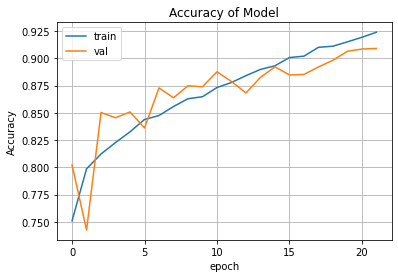

In [ ]:
plt.title('Accuracy of Model')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

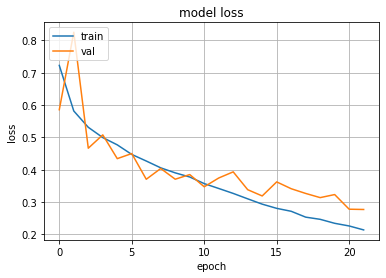

In [ ]:
plt.title('Loss of Model')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/Miczone/fingerprint/result/Xception299_1.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(directory="/content/drive/MyDrive/Miczone/fingerprint/data/test",target_size=(299,299),batch_size=7795,class_mode="sparse",)

Found 7795 images belonging to 7 classes.


In [ ]:
for Xtest,Ytest in test_generator:
  X_test = Xtest
  Y_test = Ytest
  break

In [ ]:
Xtest.shape

(7795, 299, 299, 3)

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred_idx = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(Y_test, pred_idx))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       695
         1.0       0.92      0.78      0.85       129
         2.0       0.94      0.98      0.96      3582
         3.0       0.86      0.83      0.84      1297
         4.0       0.85      0.80      0.82      1316
         5.0       0.92      0.79      0.85        76
         6.0       0.83      0.77      0.80       700

    accuracy                           0.90      7795
   macro avg       0.89      0.85      0.87      7795
weighted avg       0.90      0.90      0.90      7795



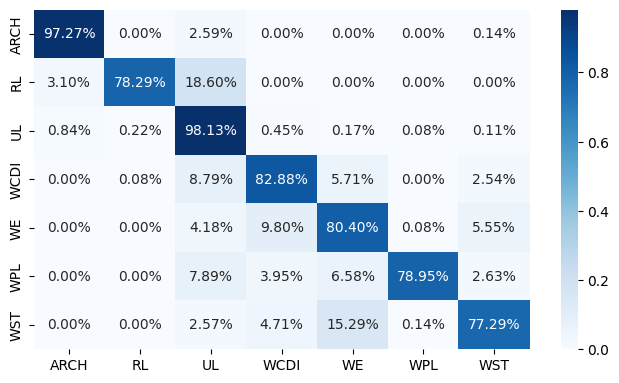

In [ ]:
import pandas as pd
import seaborn as sns
cm = confusion_matrix(Y_test,pred_idx)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmn, index=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"], columns=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"])
plt.figure(figsize = (8,4.5),dpi=100)
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='.2%')
plt.show()

In [ ]:
y